# NVIDIA NeMo Retriever Reranking Microservice

NVIDIA NeMo Retriever reranking (NeMo Retriever reranking) is a microservice which takes a query and a set of citations as input and reorders the citations based their relevance to the query. This is an important step in the retrieval process, especially when the retrieval pipeline includes citations from different datastores each with their own similarity scoring algorithms.

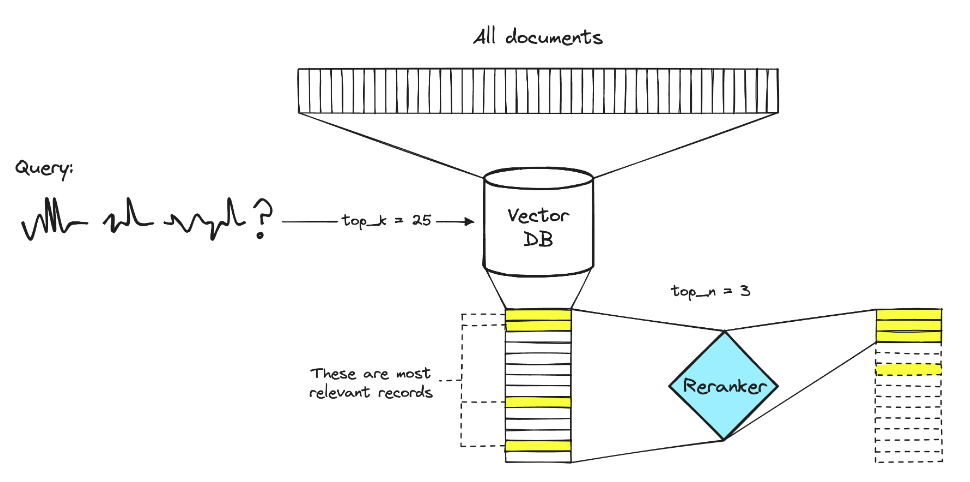

NeMo Retriever Reranking comes with a fine-tuned, commercially-usable reranker based on Mistral7B. We use half the weights, so the model is only 3.5B parameters.

The NVIDIA Retrieval Reranking Models are optimized for text question-answering ranking:

1. NV-Rerank-QA-Mistral-4B is a finetuned version of Mistral7B (mistralai/Mistral-7B-v0.1).
2. NV-Rerank-QA is a finetuned version of MiniLM L12 H384 uncased cross encoder.

Reranking is a critical piece for high accuracy and efficient retrieval pipelines. We have to main usecases for reranking:
1. Enhancing accuracy for single data sources
2. Combining results from multiple data sources

We'll see both in practice in this notebook.

## Enhancing Accuracy for Single Data Sources - Rerank Embeddings based on their relevance to the Query

Let's start with creating a dummy knowledge base that we can use as reference. 

Semantic search with vector embeddings is an efficient way to turn a large corpus of documents into a smaller corpus of relevant documents. This is done by trading accuracy for efficiency. Reranking as a tool adds accuracy back into the search by post-processing the smaller corpus of documents. Typically, ranking on the full corpus is too slow for applications.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv('../.env')

True

In [2]:
NVIDIAfunFacts = [
    "NVIDIA GH200 Grace Hopper Superchip is designed for the next generation of AI!",
    "NVIDIA GH200 (Grace Hopper Superchip) combines the Grace and Hopper architectures to deliver a CPU + GPU coherent memory model",
    "NVIDIA H200 has 141 GB of GPU memory.",
    "NVIDIA H200 has 4.8TB/s of GPU memory bandwidth.",
    "NVIDIA H100 is based on the Hopper architecture.",
    "NVIDIA A100 is based on the Ampere architecture.",
    "NVIDIA GeForce RTX 4090 is based on the Ada Lovelace architecture."
]

Check if the Reranker Microservice is running:

In [3]:
#!curl -v http://embedding-ms:8080/v1/health/ready
#!curl -v http://reranking-ms:1976/v1/health/ready

We import the reranker utilities and define a query that we want to ask our knowledge base.

In [4]:
import random
import sys
sys.path.insert(0, '../utils/')

from request_utils import *

query = "What does the GH in the NVIDIA GH200 stand for?"

A typical request to the the Reranking microservice includes a query, a list of passages, and an optional truncate parameter (either <span style="color:blue">NONE</span> or <span style="color:blue">END</span>, defaulting to <span style="color:blue">NONE</span>). 

It then reranks the passages based on relevance. Note that while many datastores will return scores for passages, those scores are not used by the Reranking microservice. Only the text of the query and candidate passages are used, and are ranked according to the model’s understanding of the content.

If truncate is <span style="color:blue">NONE</span>, the microservice will return an error for inputs whose tokenized representation exceeds the token limit for the underlying model. If truncate is <span style="color:blue">END</span>, all tokens beyond the token limit will be ignored.

Let's define our reranker with **nv-rerank-qa-mistral-4b:1** model and input the query and the sentences that we defined earlier.

In [5]:
# Call reranker passing in our query and set of passages. Returns an ordered list of index and score.
import requests

api_key = os.getenv("NVIDIA_API_KEY") 

invoke_url = "https://ai.api.nvidia.com/v1/retrieval/nvidia/nv-rerankqa-mistral-4b-v3/reranking"

headers = {
    "Authorization": f"Bearer {api_key}",
    "Accept": "application/json",
}

rerank = {
  "model": "nvidia/nv-rerankqa-mistral-4b-v3",
  "query": {"text": query},
  "passages": [{"text": sentence} for sentence in NVIDIAfunFacts]
}

# re-use connections
session = requests.Session()

response = session.post(invoke_url, headers=headers, json=rerank)

response.raise_for_status()
rankings = response.json()
print(rankings['rankings'])

[{'index': 1, 'logit': 16.3125}, {'index': 0, 'logit': 13.5859375}, {'index': 3, 'logit': -2.0390625}, {'index': 2, 'logit': -3.05859375}, {'index': 4, 'logit': -6.1171875}, {'index': 5, 'logit': -8.8359375}, {'index': 6, 'logit': -10.875}]


The results from a reranking request will include a list of objects with index and logit keys. They will be sorted descending by logit value. logit is the raw, unnormalized predictions that a model generates for each query / passage pair.

The index references the index of the sentence being referred to in the request. So if the request list included sentences ["A", "B", "C"] and the indexes in the response are 1,2,0 then the response is saying that the sorted passages order is ["C", "A", "B"].

Let's use the reranker now to rank the sentences with the order of relevancy to the Query.

In [6]:
# Now we re-order our passages according to the rerank results.
reranked_sentences = []
for rank in rankings['rankings']:
    score = rank.get('score', 0)  # Default score is 0 if 'score' key is not found
    reranked_sentences.append((format(score, '.3f'), NVIDIAfunFacts[rank['index']]))

print("query:", query)

for i, sentence in enumerate(reranked_sentences[:10], start=0):
    print(f"({i}) ({sentence[0]}) {sentence[1]}")

query: What does the GH in the NVIDIA GH200 stand for?
(0) (0.000) NVIDIA GH200 (Grace Hopper Superchip) combines the Grace and Hopper architectures to deliver a CPU + GPU coherent memory model
(1) (0.000) NVIDIA GH200 Grace Hopper Superchip is designed for the next generation of AI!
(2) (0.000) NVIDIA H200 has 4.8TB/s of GPU memory bandwidth.
(3) (0.000) NVIDIA H200 has 141 GB of GPU memory.
(4) (0.000) NVIDIA H100 is based on the Hopper architecture.
(5) (0.000) NVIDIA A100 is based on the Ampere architecture.
(6) (0.000) NVIDIA GeForce RTX 4090 is based on the Ada Lovelace architecture.


This makes sense because the Query is asking about GH200, so the reranker has ranked the relevant sentences to match that. 

Let's try the same with another query to see the difference.

In [7]:
query_2 = "What does GeForce based on?"

# Call reranker passing in our query and set of passages. Returns an ordered list of index and score.
rerank = {
  "model": "nvidia/nv-rerankqa-mistral-4b-v3",
  "query": {"text": query_2},
  "passages": [{"text": sentence} for sentence in NVIDIAfunFacts]
}

# re-use connections
session = requests.Session()

response = session.post(invoke_url, headers=headers, json=rerank)

response.raise_for_status()
rankings = response.json()
print(rankings['rankings'])


reranked_sentences = []
for rank in rankings['rankings']:
    score = rank.get('score', 0)  # Default score is 0 if 'score' key is not found
    reranked_sentences.append((format(score, '.3f'), NVIDIAfunFacts[rank['index']]))

print("query:", query_2)

for i, sentence in enumerate(reranked_sentences[:10], start=0):
    print(f"({i}) ({sentence[0]}) {sentence[1]}")

[{'index': 6, 'logit': 6.1171875}, {'index': 5, 'logit': -5.09765625}, {'index': 4, 'logit': -6.79296875}, {'index': 1, 'logit': -12.234375}, {'index': 0, 'logit': -12.234375}, {'index': 3, 'logit': -14.9453125}, {'index': 2, 'logit': -14.9453125}]
query: What does GeForce based on?
(0) (0.000) NVIDIA GeForce RTX 4090 is based on the Ada Lovelace architecture.
(1) (0.000) NVIDIA A100 is based on the Ampere architecture.
(2) (0.000) NVIDIA H100 is based on the Hopper architecture.
(3) (0.000) NVIDIA GH200 (Grace Hopper Superchip) combines the Grace and Hopper architectures to deliver a CPU + GPU coherent memory model
(4) (0.000) NVIDIA GH200 Grace Hopper Superchip is designed for the next generation of AI!
(5) (0.000) NVIDIA H200 has 4.8TB/s of GPU memory bandwidth.
(6) (0.000) NVIDIA H200 has 141 GB of GPU memory.


As expected, the reranker ranked the sentence about GeForce at the top now. 

## Combining Results from Multiple Data Sources

We'll start with setting up a Hybrid RAG pipeline for document retrieval and implement reranker to combine the results. 

Consider a pipeline with data from a semantic store, such as FAISS, as well as a BM25 store.
Each store is queried independently and returns results that the individual store considers to be highly relevant. Figuring out the overall relevance of the results is where reranking comes into play.

### Document loading and chunking into a vector database.

We'll start with loading a document and storing it in a vector database.

LangChain provides a variety of [document loaders](https://python.langchain.com/docs/integrations/document_loaders) that load various types of documents (HTML, PDF, code) from many different sources and locations (private s3 buckets, public websites). Document loaders load data from a source as **Documents**. A **Document** is a piece of text (the page_content) and associated metadata. Document loaders provide a ``load`` method for loading data as documents from a configured source. [Here](https://python.langchain.com/docs/integrations/document_loaders) are some of the document loaders available from LangChain.

In this example, we use a LangChain ``PyPDFDirectoryLoader`` to load datasheets about the NVIDIA H200 Tensor Core GPU, A100 GPU and L40 GPU. This Loads a directory with PDF files using pypdf and chunks at character level. This loader also stores page numbers in metadata.

In [8]:
! wget -O "h200-datasheet.pdf" -nc --user-agent="Mozilla" https://nvdam.widen.net/content/udc6mzrk7a/original/hpc-datasheet-sc23-h200-datasheet-3002446.pdf

File ‘h200-datasheet.pdf’ already there; not retrieving.


In [9]:
! wget -O "l40-datasheet.pdf" -nc --user-agent="Mozilla" https://www.nvidia.com/content/dam/en-zz/Solutions/design-visualization/support-guide/NVIDIA-L40-Datasheet-January-2023.pdf

File ‘l40-datasheet.pdf’ already there; not retrieving.


In [10]:
! wget -O "a100-datasheet.pdf" -nc --user-agent="Mozilla" https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf

File ‘a100-datasheet.pdf’ already there; not retrieving.


In [11]:
# Upload Directory of Documents
from langchain_community.document_loaders import PyPDFDirectoryLoader

data_loader = PyPDFDirectoryLoader('.')
data = data_loader.load()

print("Files found: ", len(data))

Files found:  9


In [12]:
#data

<br>

Once documents have been loaded, they are often transformed. One method of transformation is known as **chunking**, which breaks down large pieces of text, for example, a long document, into smaller segments. This technique is valuable because it helps [optimize the relevance of the content returned from the vector database](https://www.pinecone.io/learn/chunking-strategies/). 

LangChain provides a [variety of document transformers](https://python.langchain.com/docs/integrations/document_transformers/), such as text splitters. In this example, we use a [``RecursiveCharacterTextSplitter``](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.RecursiveCharacterTextSplitter.html). The ``RecursiveCharacterTextSplitter`` is designed to divide a large text into smaller chunks based on a specified chunk size. It employs recursion as its core mechanism for splitting text, utilizing a predefined set of characters (e.g., "\n\n", "\n", " ", "") to determine where splits should occur. The process begins by attempting to split the text using the first character in the set. If the resulting chunks are still larger than the desired chunk size, it proceeds to the next character in the set and attempts to split again. This process continues until all chunks adhere to the specified maximum chunk size.

There are some nuanced complexities to text splitting since semantically related text, in theory, should be kept together. 

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=100,
    separators=["\n\n", "\n", ".", ";", ",", " ", ""],
)

document_chunks = text_splitter.split_documents(data)

The Reranking microservice is an integral part of the NeMo Retriever Microservice ranked_hybrid pipeline, but it can be used standalone to rerank any query / passage pairs.

In [14]:
print("Number of chunks from the document:", len(document_chunks))

Number of chunks from the document: 23


In [15]:
from langchain_community.embeddings import NeMoEmbeddings
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_nvidia_ai_endpoints import NVIDIARerank
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embedding_model = NVIDIAEmbeddings(model="NV-Embed-QA")
ranker = NVIDIARerank()


# #HuggingFace
# embedding_model = HuggingFaceEmbeddings(
#     model_name="intfloat/e5-large-v2",
#     model_kwargs={"device": "cpu"},
#     encode_kwargs={"normalize_embeddings": False},
# )


In [16]:
# Create FAISS vector store from NREM 
vector_store_from_document = FAISS.from_documents(document_chunks, embedding=embedding_model)

<br>

Next let's look at creating a sparse retrieval pipeline using BM25 Store.

### BM25 Relevant Documents 

In [17]:
from langchain_community.retrievers import BM25Retriever


# Initialize the BM25 retriever
bm25_retriever = BM25Retriever.from_documents(document_chunks)
bm25_retriever.k =  2  # Retrieve top 2 results

In [18]:
# import elasticsearch
# client = elasticsearch.Elasticsearch("http://localhost:9200")

Verify Elasticsearch is running by using the following curl command: curl -X GET "localhost:9200/"

In [19]:
# !curl -X GET "localhost:9200/"

#### Create and Configure the langchain-index Store

In [20]:
# index_config = {
#     "settings": {
#         "number_of_shards": 1,
#         "number_of_replicas": 1
#     },
#     "mappings": {
#         "properties": {
#             "page_content" : { "type" : "text"},
#             "metadata" : { "type" : "text"}
#         }
#     }
# }

In [21]:
# client.indices.create(index='langchain-index', body=index_config)

In [22]:
#Handle Exceptions
# from elasticsearch.exceptions import RequestError

# try:
#     client.indices.create(index='langchain-index', body=index_config)
# except RequestError as e:
#     print(f"An error occurred: {e}")

In [23]:
# from langchain_community.retrievers import ElasticSearchBM25Retriever

# bm25_retriever = ElasticSearchBM25Retriever(
#     client=client,
#     index_name="langchain-index"
# )

In [24]:
query = "What does the H in the NVIDIA H200 stand for?"

In [25]:
bm25_docs = bm25_retriever.get_relevant_documents(query)

/Users/sagdesai/Desktop/work/workshop2/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [26]:
bm25_docs

[Document(page_content='Ready to Get Started?\nTo learn more about the NVIDIA H200 Tensor Core GPU,  \nvisit nvidia.com/h200\n© 2024 NVIDIA Corporation and affiliates. All rights reserved. NVIDIA, the NVIDIA logo, HGX, Hopper, MGX,  NVIDIA-\nCertified Systems, and NVLink are trademarks and/or registered trademarks of NVIDIA Corporation and affiliates in \nthe U.S. and other countries. Other company and product names may be trademarks of the respective owners with \nwhich they are associated. 3367480. JUL24', metadata={'source': 'h200-datasheet.pdf', 'page': 3}),
 Document(page_content='NVIDIA H200 Tensor Core GPU\u2002|\u2002Datasheet\u2002|\u2002 3Unleashing AI Acceleration for Mainstream Enterprise Servers \nWith H200 NVL\nThe NVIDIA H200 NVL is the ideal choice for customers with space constraints within  \nthe data center, delivering acceleration for every AI and HPC workload regardless of size. \nWith a 1.5X memory increase and a 1.2X bandwidth increase over the previous generatio

### Semantic Relevant Documents

Now we define the Semantic Retriever using FAISS Vector Index. 

In [27]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = NVIDIAEmbeddings(model="NV-Embed-QA")

# #HuggingFace
# embeddings = HuggingFaceEmbeddings(
#     model_name="intfloat/e5-large-v2",
#     model_kwargs={"device": "cpu"},
#     encode_kwargs={"normalize_embeddings": False},
# )

sem_retriever = vector_store_from_document.as_retriever()

In [28]:
sem_docs = sem_retriever.get_relevant_documents(query)

In [29]:
sem_docs

[Document(page_content='NVIDIA H200 Tensor Core GPU\u2002|\u2002Datasheet\u2002|\u2002 2Supercharge High-Performance Computing\nMemory bandwidth is crucial for HPC applications, as it enables faster data \ntransfer and reduces complex processing bottlenecks. For memory-intensive \nHPC applications like simulations, scientific research, and artificial intelligence, \nthe H200’s higher memory bandwidth ensures that data can be accessed and \nmanipulated efficiently, leading to 110X faster time to results.\nPreliminary specifications. May be subject to change.\nHPC MILC- dataset NERSC Apex Medium | HGX H200 4-GPU | dual Sapphire Rapids 8480\nHPC Apps- CP2K: dataset H2O-32-RI-dRPA-96points | GROMACS: dataset STMV | ICON: dataset r2b5 | MILC: dataset NERSC \nApex Medium | Chroma: dataset HMC Medium | Quantum Espresso: dataset AUSURF112 | 1x H100 SXM | 1x H200 SXM.\nReduce Energy and TCO\nWith the introduction of H200, energy efficiency and TCO reach new levels. This \ncutting-edge technolog

### Hybrid retriever

In [30]:
from langchain.retrievers import EnsembleRetriever
from langchain.chains import RetrievalQA
import os
from langchain_nvidia_ai_endpoints import ChatNVIDIA


# Initialize LLM from NVIDIA AI Foundation Endpoints
# os.environ["NVIDIA_API_KEY"] = "nvapi-***" 
llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")

# Initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, sem_retriever],
                                       weights=[0.4, 0.6])

# Retrieve relevant documents/products
docs = ensemble_retriever.get_relevant_documents(query)

qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=ensemble_retriever)
qa.run(query)


/Users/sagdesai/Desktop/work/workshop2/.venv/lib/python3.10/site-packages/langchain_nvidia_ai_endpoints/_common.py:537: UserWarning: Found meta/llama-3.1-8b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(
/Users/sagdesai/Desktop/work/workshop2/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'Unfortunately, the provided text does not explicitly mention what the "H" in NVIDIA H200 stands for. It only provides information about the specifications, benefits, and features of the NVIDIA H200 Tensor Core GPU.\n\nHowever, according to NVIDIA\'s website and other sources, the "H" in the NVIDIA H200 likely stands for "Hopper", which is the codename for the NVIDIA H100 and H200 Tensor Core GPUs, based on the NVIDIA Hopper architecture.'


### Combine and Rank Documents

In [31]:
from langchain_nvidia_ai_endpoints import NVIDIARerank
import os

# os.environ["NVIDIA_API_KEY"] = "nvapi-***" 
ranker = NVIDIARerank()

all_docs = bm25_docs + sem_docs

reranked_docs = ranker.compress_documents(query=query, documents=all_docs)

In [32]:
reranked_docs[0]

Document(page_content='NVIDIA H200 Tensor Core GPU\u2002|\u2002Datasheet\u2002|\u2002 3Unleashing AI Acceleration for Mainstream Enterprise Servers \nWith H200 NVL\nThe NVIDIA H200 NVL is the ideal choice for customers with space constraints within  \nthe data center, delivering acceleration for every AI and HPC workload regardless of size. \nWith a 1.5X memory increase and a 1.2X bandwidth increase over the previous generation, \ncustomers can fine-tune LLMs within a few hours and experience LLM inference 1.8X faster.\nEnterprise-Ready: AI Software Streamlines Development  \nand Deployment \nNVIDIA H200 NVL is bundled with a five-year NVIDIA AI Enterprise  subscription \nand simplifies the way you build an enterprise AI-ready platform. H200 accelerates \nAI development and deployment for production-ready generative AI solutions, \nincluding computer vision, speech AI, retrieval augmented generation (RAG), \nand more. NVIDIA AI Enterprise includes NVIDIA NIMTM, a set of easy-to-use \nm

In [33]:
for doc in all_docs:
    # Access the metadata of the document
    metadata = doc.metadata
    # Print the relevance score if it exists in the metadata
    if 'relevance_score' in metadata:
        print(f"Document ID: {metadata.get('source')}, Relevance Score: {metadata.get('relevance_score')}")

Document ID: h200-datasheet.pdf, Relevance Score: 1.2099609375
Document ID: h200-datasheet.pdf, Relevance Score: 2.79296875
Document ID: h200-datasheet.pdf, Relevance Score: 1.826171875
Document ID: h200-datasheet.pdf, Relevance Score: 1.2099609375
Document ID: h200-datasheet.pdf, Relevance Score: 2.79296875
Document ID: h200-datasheet.pdf, Relevance Score: 2.0


In [34]:
for doc in reranked_docs:
    # Access the metadata of the document
    metadata = doc.metadata
    # Print the relevance score if it exists in the metadata
    if 'relevance_score' in metadata:
        print(f"Document ID: {metadata.get('source')}, Relevance Score: {metadata.get('relevance_score')}")

Document ID: h200-datasheet.pdf, Relevance Score: 2.79296875
Document ID: h200-datasheet.pdf, Relevance Score: 2.79296875
Document ID: h200-datasheet.pdf, Relevance Score: 2.0
Document ID: h200-datasheet.pdf, Relevance Score: 1.826171875
Document ID: h200-datasheet.pdf, Relevance Score: 1.2099609375


Repeating this workflow for another Query like we did before. 

In [35]:
query_3 = "What does the A in the NVIDIA A100 stand for?"

In [36]:
bm25_docs = bm25_retriever.get_relevant_documents(query_3)
sem_docs = sem_retriever.get_relevant_documents(query_3)

In [37]:
all_docs_2 = bm25_docs + sem_docs
reranked_docs = ranker.compress_documents(query=query_3, documents=all_docs_2)

In [38]:
for doc in all_docs_2:
    # Access the metadata of the document
    metadata = doc.metadata
    # Print the relevance score if it exists in the metadata
    if 'relevance_score' in metadata:
        print(f"Document ID: {metadata.get('source')}, Relevance Score: {metadata.get('relevance_score')}")

Document ID: a100-datasheet.pdf, Relevance Score: -1.7939453125
Document ID: a100-datasheet.pdf, Relevance Score: -1.5107421875
Document ID: a100-datasheet.pdf, Relevance Score: 0.346435546875
Document ID: a100-datasheet.pdf, Relevance Score: -1.5107421875
Document ID: a100-datasheet.pdf, Relevance Score: -1.7939453125


In [39]:
for doc in reranked_docs:
    # Access the metadata of the document
    metadata = doc.metadata
    # Print the relevance score if it exists in the metadata
    if 'relevance_score' in metadata:
        print(f"Document ID: {metadata.get('source')}, Relevance Score: {metadata.get('relevance_score')}")

Document ID: a100-datasheet.pdf, Relevance Score: 0.346435546875
Document ID: a100-datasheet.pdf, Relevance Score: -1.5107421875
Document ID: a100-datasheet.pdf, Relevance Score: -1.5107421875
Document ID: a100-datasheet.pdf, Relevance Score: -1.7939453125
Document ID: a100-datasheet.pdf, Relevance Score: -1.7939453125


Here we can see the retrieved documents before and after reranking. The reranker re-orders the retrieved documents on the basis of the relevance score. 

In [40]:
query_4 = "What does the L stand for in L40?"

In [41]:
bm25_docs = bm25_retriever.get_relevant_documents(query_4)
sem_docs = sem_retriever.get_relevant_documents(query_4)

In [42]:
all_docs_3 = bm25_docs + sem_docs
reranked_docs = ranker.compress_documents(query=query_4, documents=all_docs_3)

In [43]:
for doc in all_docs_3:
    # Access the metadata of the document
    metadata = doc.metadata
    # Print the relevance score if it exists in the metadata
    if 'relevance_score' in metadata:
        print(f"Document ID: {metadata.get('source')}, Relevance Score: {metadata.get('relevance_score')}")

Document ID: a100-datasheet.pdf, Relevance Score: -1.7939453125
Document ID: a100-datasheet.pdf, Relevance Score: -15.3671875
Document ID: l40-datasheet.pdf, Relevance Score: -2.248046875
Document ID: l40-datasheet.pdf, Relevance Score: -2.9609375
Document ID: l40-datasheet.pdf, Relevance Score: -2.111328125
Document ID: a100-datasheet.pdf, Relevance Score: -13.5703125


In [44]:
for doc in reranked_docs:
    # Access the metadata of the document
    metadata = doc.metadata
    # Print the relevance score if it exists in the metadata
    if 'relevance_score' in metadata:
        print(f"Document ID: {metadata.get('source')}, Relevance Score: {metadata.get('relevance_score')}")

Document ID: l40-datasheet.pdf, Relevance Score: -2.111328125
Document ID: l40-datasheet.pdf, Relevance Score: -2.248046875
Document ID: l40-datasheet.pdf, Relevance Score: -2.9609375
Document ID: a100-datasheet.pdf, Relevance Score: -13.5703125
Document ID: a100-datasheet.pdf, Relevance Score: -15.3671875


Therefore in conclusion, reranker is very effective and integral part of an efficient document retrieval pipeline. By ranking the most relevant documents in order, the augmented context to the LLM is more relvant and adds to the performance of the Retrieval Augmented Generation Pipelien. 

In [45]:
from langchain.retrievers import EnsembleRetriever
from langchain.chains import RetrievalQA
from langchain_nvidia_ai_endpoints import ChatNVIDIA

from langchain.retrievers import ContextualCompressionRetriever
from langchain_nvidia_ai_endpoints import NVIDIARerank

compressor = NVIDIARerank()

# Initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, sem_retriever],
                                       weights=[0.4, 0.6])

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=ensemble_retriever
)

# Initialize LLM from NVIDIA AI Foundation Endpoints
# os.environ["NVIDIA_API_KEY"] = "nvapi-***" 
llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")


chain = RetrievalQA.from_chain_type(llm=llm, retriever=compression_retriever)
chain.invoke(query)

/Users/sagdesai/Desktop/work/workshop2/.venv/lib/python3.10/site-packages/langchain_nvidia_ai_endpoints/_common.py:537: UserWarning: Found meta/llama-3.1-8b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(


{'query': 'What does the H in the NVIDIA H200 stand for?',
 'result': 'Based on the provided context, the "H" in NVIDIA H200 stands for "Hopper" which refers to the NVIDIA Hopper architecture, the basis for the NVIDIA H200 Tensor Core GPU.'}